# Analyse attrition ESN – Projet 5

# Table des matières

## 1. Introduction
- Objectif : Prédire l'attrition des employés (départs ESN)
- Contexte et usage du projet

## 2. Imports & Setup
- Importations des modules Python
- Réglages globaux (warnings, matplotlib, seaborn…)

## 3. Chargement des données
- Lecture des fichiers SIRH, sondage, évaluation
- Vérification des identifiants uniques et correspondance

## 4. Nettoyage des Données
- Nettoyage : suppression, corrections, fusion

## 5. Fonctions Utilitaires
- Cellule dédiée : helpers de visualisation, scoring, feature engineering, encodage, ...
  - `plot_feature_distributions`
  - `add_salary_group_feature`, `create_salary_features`
  - `plot_heatmaps_cat`
  - Preprocessing pipeline helpers (`build_preprocessor`, `build_model_pipelines`…)

## 6. Feature Engineering
- Création des features :
  - Variables composites (poste-département, nouveau responsable…)
  - Transformation de salaire, score carrière, indice évolution
  - Découpage des salaires, features catégorielles

## 7. Préparation des jeux d’apprentissage
- Sélection/features list
- Encodage target
- Split train/test stratifié
- Pipeline preprocessing

## 8. Construction des Pipelines de modèles
- Modèle : XGBoost
- Pipelines avec balancing natif et resampling (SMOTE)

## 9. Validation Croisée & Comparaisons
- Évaluation cross-validation (accuracy, recall, F1…)
- Matrices de confusion, courbes seuils
- Comparatif balanced/unbalanced, avec/without sampling

## 10. Optimisation des Hyperparamètres
- GridSearch sur XGBoost
- Affichage best params, best recall, F1

## 11. Évaluation Finale (Test Set)
- Prédiction sur jeu de test
- Calcul des scores, matrice de confusion, affichage grille

## 12. Interprétabilité & Explicabilité
- Importance des coefficients (logreg)
- SHAP global/local

## 1. Introduction

**Objectif :**  
Déployer un modèle de machine learning permettant de prédire l'attrition des employés (départs volontaires) au sein de notre ESN à partir de données RH et d'évaluations internes.

**Contexte :**  
Ce projet vise à aider la direction et les managers à anticiper les risques de départ, optimiser la gestion des talents et mettre en place des actions de fidélisation ciblées grâce à l'analyse prédictive.
grâce à cette Application, il pourront effectuer la prédiction pour chaque employé, en toute autonomie.

## 2. Imports & Setup

In [1]:
# Imports des modules principaux
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import psycopg2
import ipywidgets as widgets
import shap
import joblib
import os
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, fbeta_score, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sqlalchemy import create_engine
from IPython.display import display, HTML

# Réglages globaux
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API")
warnings.filterwarnings('ignore', category=UserWarning)

## 3. Chargement des données

In [2]:
# Chargement des fichiers
df_sirh = pd.read_csv("../data/raw/extrait_sirh.csv")
df_sondage = pd.read_csv("../data/raw/extrait_sondage.csv")
df_eval = pd.read_csv("../data/raw/extrait_eval.csv")

# Vérification de l'unicité des identifiants
print("id_employee unique dans SIRH ?", df_sirh['id_employee'].is_unique)
print("eval_number unique dans eval ?", df_eval['eval_number'].is_unique)
print("code_sondage unique dans sondage ?", df_sondage['code_sondage'].is_unique)

# Extraction numérique des identifiants pour la correspondance
df_eval['eval_number_num'] = df_eval['eval_number'].str.extract(r'E_(\d+)').astype(int)

# Sets des valeurs pour l'intersection
valeurs_eval = set(df_eval['eval_number_num'].dropna().astype(int))
valeurs_id = set(df_sirh['id_employee'])
valeurs_sondage = set(df_sondage['code_sondage'])

intersection = valeurs_id & valeurs_eval & valeurs_sondage
print("Taille de l'intersection identifiants communs :", len(intersection))

print("Nombre unique dans SIRH :", len(valeurs_id))
print("Nombre unique dans eval :", len(valeurs_eval))
print("Nombre unique dans sondage :", len(valeurs_sondage))

# Fusion des jeux de données via l'identifiant commun
df_central = (
    df_sirh.merge(
        df_eval.assign(eval_number_num=df_eval['eval_number'].str.extract(r'E_(\d+)').astype(int)),
        left_on='id_employee', right_on='eval_number_num'
    )
    .merge(df_sondage, left_on='id_employee', right_on='code_sondage')
)

# Aperçu du résultat
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)  # Toutes les colonnes visibles

display(df_central)


id_employee unique dans SIRH ? True
eval_number unique dans eval ? True
code_sondage unique dans sondage ? True
Taille de l'intersection identifiants communs : 1470
Nombre unique dans SIRH : 1470
Nombre unique dans eval : 1470
Nombre unique dans sondage : 1470


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,eval_number_num,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,1,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,2,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,4,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,5,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,7,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,M,2571,Marié(e),Consulting,Consultant,4,80,17,5,2,3,4,2,4,3,3,E_2061,3,Non,17 %,2061,Non,1,3,1,2061,23,2,Transformation Digitale,Y,Frequent,0,3
1466,2062,39,M,9991,Marié(e),Consulting,Manager,4,80,9,7,7,4,2,3,1,1,3,E_2062,3,Non,15 %,2062,Non,1,5,1,2062,6,1,Transformation Digitale,Y,Occasionnel,1,7
1467,2064,27,M,6142,Marié(e),Consulting,Tech Lead,1,80,6,6,2,2,4,2,2,2,3,E_2064,4,Oui,20 %,2064,Non,1,0,1,2064,4,3,Infra & Cloud,Y,Occasionnel,0,3
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,9,6,4,2,2,2,4,2,E_2065,3,Non,14 %,2065,Non,0,3,1,2065,2,3,Transformation Digitale,Y,Frequent,0,8


## 4. Nettoyage des Données

In [3]:
# --- Suppression/renommage de colonnes inutiles ou redondantes après fusion
colonnes_a_supprimer = [
    'eval_number', 'eval_number_num', 'code_sondage',
    'nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants'
]

df_central = df_central.drop(columns=colonnes_a_supprimer, errors='ignore')

print("\nShape du DataFrame central nettoyé :", df_central.shape)
display(df_central.head(5))


Shape du DataFrame central nettoyé : (1470, 29)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,2,3,2,4,1,1,3,Oui,11 %,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,3,2,2,2,4,3,4,Non,23 %,Non,1,3,8,1,Infra & Cloud,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,4,2,1,3,2,3,3,Oui,15 %,Oui,0,3,2,2,Autre,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,4,3,1,3,3,3,3,Oui,11 %,Non,0,3,3,4,Infra & Cloud,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,1,3,1,2,4,3,3,Non,12 %,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2


## 5. Fonctions Utilitaires

### Helpers de feature engineering et encodage

In [4]:
# --- Fonction pour bel affichage des scores
def pretty_metrics(models, X_test, y_test):
    rows = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred) * 100
        prec = precision_score(y_test, y_pred, zero_division=0) * 100
        rec = recall_score(y_test, y_pred) * 100
        f1 = f1_score(y_test, y_pred) * 100
        f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0) * 100
        pr_auc = average_precision_score(y_test, model.predict_proba(X_test)[:,1]) * 100 if hasattr(model, "predict_proba") else None
        rows.append({
            "Modèle": name,
            "Accuracy (%)": f"{acc:.1f}",
            "Précision (%)": f"{prec:.1f}",
            "Rappel (%)": f"{rec:.1f}",
            "F1 (%)": f"{f1:.1f}",
            "F2 (%)": f"{f2:.1f}",
            "PR-AUC (%)": f"{pr_auc:.1f}" if pr_auc is not None else "N/A"
        })
    df = pd.DataFrame(rows)
    display(df.set_index('Modèle'))

# --- Fonction pour d'affichage pour les seuils ---
def metrics_table(y_true, y_pred, y_proba, model_name, seuil):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, zero_division=0) * 100
    rec = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0) * 100
    pr_auc = average_precision_score(y_true, y_proba) * 100
    return {
        "Modèle": model_name,
        "Seuil": f"{seuil:.2f}",
        "Accuracy (%)": f"{acc:.1f}",
        "Précision (%)": f"{prec:.1f}",
        "Rappel (%)": f"{rec:.1f}",
        "F1 (%)": f"{f1:.1f}",
        "F2 (%)": f"{f2:.1f}",
        "PR-AUC (%)": f"{pr_auc:.1f}"
    }
    
# --- Fonction de découpage en groupes de salaires
def add_salary_group_feature(df, group_cols=None, col_revenu='revenu_mensuel', feature_name='salary_group', labels=None):
    if labels is None:
        labels = ["Très bas", "Bas", "Moyen", "Haut"]
    if group_cols is not None:
        q1 = df.groupby(group_cols)[col_revenu].transform(lambda x: x.quantile(0.25))
        mediane = df.groupby(group_cols)[col_revenu].transform('median')
        q3 = df.groupby(group_cols)[col_revenu].transform(lambda x: x.quantile(0.75))
    else:
        q1 = pd.Series(df[col_revenu].quantile(0.25), index=df.index)
        mediane = pd.Series(df[col_revenu].median(), index=df.index)
        q3 = pd.Series(df[col_revenu].quantile(0.75), index=df.index)
    conditions = [
        df[col_revenu] < q1,
        (df[col_revenu] >= q1) & (df[col_revenu] < mediane),
        (df[col_revenu] > q3),
        (df[col_revenu] >= mediane) & (df[col_revenu] <= q3)
    ]
    df[feature_name] = np.select(conditions, labels, default='Moyen')
    return df

def create_salary_features(df, col_revenu='revenu_mensuel'):
    labels = ["Très bas", "Bas", "Moyen", "Haut"]
    df = add_salary_group_feature(df, group_cols=None, col_revenu=col_revenu, feature_name="salaire_cat", labels=labels)
    df["salaire_cat_eq"] = pd.cut(df[col_revenu], bins=4, labels=labels)
    df = add_salary_group_feature(df, group_cols=['poste_departement'], col_revenu=col_revenu, feature_name="position_salaire_poste", labels=labels)
    df = add_salary_group_feature(df, group_cols=['poste_departement', 'annees_dans_le_poste_actuel'], col_revenu=col_revenu, feature_name="position_salaire_poste_anc", labels=labels)
    return df

# --- Preprocessing pipeline helpers
def build_preprocessor(features_num, features_ord, features_cat, features_bin, ord_mappings=None):
    ord_pipe = Pipeline([
        ('ordinal', OrdinalEncoder(categories=ord_mappings)),
        ('scaler', StandardScaler())
    ])
    bin_pipe = Pipeline([
        ('label', OrdinalEncoder())
    ])
    num_pipe = StandardScaler()
    cat_pipe = OneHotEncoder(handle_unknown='ignore')
    return ColumnTransformer([
        ('num', num_pipe, features_num),
        ('ord', ord_pipe, features_ord),
        ('cat', cat_pipe, features_cat),
        ('bin', bin_pipe, features_bin)
    ])

def build_model_pipelines(models, preprocessor):
    return {name: Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ]) for name, clf in models.items()}


### Helpers de scoring, validation croisée et matrice de confusion

In [21]:
# --- Scoring multi-métriques (pour cross-validation) ---

# 1. Scale_pos_weight pour XGB
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

def get_scoring_dict(pos_label=1):
    return {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, pos_label=pos_label, zero_division=0),
        'recall': make_scorer(recall_score, pos_label=pos_label, zero_division=0),
        'f1': make_scorer(f1_score, pos_label=pos_label, zero_division=0),
        'f2': make_scorer(fbeta_score, beta=2, pos_label=pos_label, zero_division=0),
        'pr_auc': 'average_precision'
    }

def crossval_score_models(pipelines, X, y, cv=5, scoring=None):
    results = []
    for name, pipe in pipelines.items():
        cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring)
        results.append({
            'Model': name,
            'Accuracy': cvres['test_accuracy'].mean(),
            'Precision': cvres['test_precision'].mean(),
            'Recall': cvres['test_recall'].mean(),
            'F1': cvres['test_f1'].mean(),
            'F2': cvres['test_f2'].mean() if 'test_f2' in cvres else None,
            'PR-AUC': cvres['test_pr_auc'].mean() if 'test_pr_auc' in cvres else None
        })
    df = pd.DataFrame(results)
    for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'PR-AUC']:
        if col in df.columns:
            df[col] = (df[col] * 100).round(1)
    return df

def find_optimal_threshold_cv(model, X_train, y_train, beta=2, n_splits=5):
    thresholds = np.linspace(0, 1, 101)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresholds = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        f2_scores = [fbeta_score(y_fold_val, (y_proba_val >= t), beta=beta) for t in thresholds]
        best_idx = np.argmax(f2_scores)
        best_thresholds.append(thresholds[best_idx])
    return np.mean(best_thresholds)  # seuil optimal moyen CV

# --- Matrice de confusion cross-validation (sans changement) ---
def confusion_matrix_cv(pipeline, X, y, cv=5, labels_txt=['Non','Oui']):
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_txt, yticklabels=labels_txt)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title("Matrice de confusion - Cross-Val (train set)")
    plt.show()


### Helpers pour resampling

In [6]:
# --- Helper: pipeline avec resampling (SMOTE ou under)
def build_resampling_pipeline(preprocessor, model, oversample=None, undersample=None):
    steps = [('preprocess', preprocessor)]
    if oversample:
        steps.append(('oversample', oversample))
    if undersample:
        steps.append(('undersample', undersample))
    steps.append(('clf', model))
    return ImbPipeline(steps)

def make_models(preprocessor, balance_logreg, balance_xgb, resampling=None, y_train=None):
    n_negative = (y_train == 0).sum()
    n_positive = (y_train == 1).sum()
    scale_pos_weight = n_negative / n_positive if (balance_xgb and n_positive > 0) else 1
    models = {
        'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
    }
    pipelines = {}
    for name, model in models.items():
        if resampling == 'smote':
            pipe = build_resampling_pipeline(preprocessor, model, oversample=SMOTE())
        elif resampling == 'undersample':
            pipe = build_resampling_pipeline(preprocessor, model, undersample=RandomUnderSampler())
        else:
            pipe = build_resampling_pipeline(preprocessor, model)  # no resampling
        pipelines[name] = pipe
    return pipelines


## 5bis. Définition de la Target et des features initiales

### Définition de la Target
On souhaite ici endiguer un phénomène de Turn-Over, on veut donc prédire ou expliquer les démissions.
La Target sera donc "**a_quitte_l_entreprise**"

In [7]:
target = 'a_quitte_l_entreprise'

### Liste des features initiales

In [8]:
features_init = [
    'id_employee',
    'age',
    'genre',
    'revenu_mensuel',
    'statut_marital',
    'departement',
    'poste',
    'nombre_experiences_precedentes',
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement',
    'note_evaluation_precedente',
    'niveau_hierarchique_poste',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'heure_supplementaires',
    'augementation_salaire_precedente',
    'a_quitte_l_entreprise',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'distance_domicile_travail',
    'niveau_education',
    'domaine_etude',
    'frequence_deplacement',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'note_evaluation_actuelle'
]

## 6. Feature Engineering

La plupart des postes sont regroupés dans le département Consulting, le département Commercial contient 3 postes, et RH seulement 2. Le poste Senior Manager est le seul réparti sur plusieurs départements (les 3). Pour l'analyse, Nous allons créer une feature composite de ces deux features.

Nous allons également convertir l'augmentation de salaire en valeur numérique (au lieu de XX%), une feature boléenne de changement de responsable, quatres features de groupes de salaires (global en 4 groupes équivalents, ou selon les quartiles, au global, par poste, et par poste + ancienneté), Un indice d'évolution de salaire annuel depuis la dernière promotion, et un score de carrière (indice d'évolution de salaire/ancienneté totale, pondéré par le salaire).

In [9]:
# --- Feature engineering ---
df_central['attrition_num'] = (df_central['a_quitte_l_entreprise'] == 'Oui').astype(int)

# 1 - Feature composite Poste-Departement
df_central['poste_departement'] = df_central['poste'] + '_' + df_central['departement']

# 2 - Feature Changement de Responsable depuis l'année précédente
df_central['nouveau_responsable'] = np.where(df_central['annes_sous_responsable_actuel'] == 0, 'Oui', 'Non')

# 3 - Feature Conversion augementation_salaire_precedente en numérique (pour modéliser sur la valeur)
df_central['augmentation_salaire_precedente'] = (
    df_central['augementation_salaire_precedente']
    .str.replace('%', '', regex=False)
    .astype(int)
)

# 4 - Feature Indice d'évolution salariale (ratio annuel du pourcentage d'augmentation depuis la dernière promotion)
# Plus l'indice est élevé, meilleure est l'évolution.
df_central['indice_evolution_salaire'] = (
    (df_central['augmentation_salaire_precedente'] + 1e-6) / (df_central['annees_depuis_la_derniere_promotion'] + 1)
)

ordre_labels = ["Très bas", "Bas", "Moyen", "Haut"]
df_central['indice_evol_cat'] = pd.qcut(df_central['indice_evolution_salaire'], q=4, labels=ordre_labels)

# 5 - Feature Score de carrière (indice évolution de salaire, divisé par années d'ancienneté, multiplié par log du salaire)
df_central['score_evolution_carriere'] = (
    df_central['indice_evolution_salaire'] *      # effet direct de l'évolution
    (1 / (df_central['annees_dans_l_entreprise'] + 1)) *  # pénalise la stagnation si très ancien
    np.log1p(df_central['revenu_mensuel'])        # pondère par le niveau de salaire (logarithme stabilise)
)

df_central['score_carriere_cat'] = pd.qcut(df_central['score_evolution_carriere'], q=4, labels=ordre_labels)

# 6 - Features Catégories de Salaires (découpage en 4 parties égales, ou en quantiles globaux, ou par poste, ou par poste + ancienneté)
df_central = create_salary_features(df_central, col_revenu='revenu_mensuel')

print("Features ajoutées")

Features ajoutées


## 7. Préparation des jeux d'apprentissage

### Features list

In [10]:
features_id = [
    'id_employee'
]

features_num = [ #(23)
    'age',
    'revenu_mensuel',
    'nombre_experiences_precedentes', 
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement',
    'note_evaluation_actuelle',
    'note_evaluation_precedente',
    'niveau_hierarchique_poste',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'distance_domicile_travail',
    'niveau_education',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'augmentation_salaire_precedente', 
    'score_evolution_carriere',
    'indice_evolution_salaire'
]

features_ord = [ #(6)
    'frequence_deplacement',
    'salaire_cat',
    'salaire_cat_eq', 
    'position_salaire_poste',
    'position_salaire_poste_anc', 
    'score_carriere_cat',
    'indice_evol_cat'
]

ord_mappings = [
    ['Aucun', 'Occasionnel', 'Frequent'],  # frequence_deplacement
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # salaire_cat
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # salaire_cat_eq
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # position_salaire_poste
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # position_salaire_poste_anc
    ['Très bas', 'Bas', 'Moyen', 'Haut'],  # score_carriere_cat
    ['Très bas', 'Bas', 'Moyen', 'Haut']   # indice_evol_cat
]

features_cat = [ #(3)
    'statut_marital',
    'domaine_etude',
    'poste_departement'
]

features_bin = [ #(3)
    'genre',
    'heure_supplementaires',
    'nouveau_responsable'
]

# Target encodée
target = 'attrition_num'

all_features = features_id + features_num + features_ord + features_cat + features_bin + [target]
data_subset = df_central[all_features].copy()

### Connection BDD

In [11]:
load_dotenv()

db_name = os.getenv("DB_NAME")
db_host = os.getenv("DB_SYS_HOST")
db_port = os.getenv("DB_SYS_PORT", "5432")

credentials = {
    "superadmin": {
        "dbname": "postgres",
        "user": os.getenv("DB_SYS_USER"),
        "password": os.getenv("DB_SYS_PASSWORD")
    },
    "admin": {
        "dbname": db_name,
        "user": os.getenv("DB_USER_ADMIN"),
        "password": os.getenv("DB_PW_ADMIN")
    },
    "log": {
        "dbname": db_name,
        "user": os.getenv("DB_USER_LOG"),
        "password": os.getenv("DB_PW_LOG")
    },
    "demo": {
        "dbname": db_name,
        "user": os.getenv("DB_USER_DEMO"),
        "password": os.getenv("DB_PW_DEMO")
    }
}

def make_pg_conn(role):
    cred = credentials[role]
    print(f"Ouverture connexion {role}: db={cred['dbname']}, user={cred['user']}...")
    return psycopg2.connect(
        dbname=cred["dbname"],
        user=cred["user"],
        password=cred["password"],
        host=db_host,
        port=db_port
    )

# Usage plus tard dans le code :
# conn = make_pg_conn("admin")
# cur = conn.cursor()
# cur.execute(...)
# conn.close()


In [12]:
# Instanciation de la BDD et gestion droits propriétaires/roles
sys_conn = make_pg_conn("superadmin")
sys_conn.autocommit = True
sys_cur = sys_conn.cursor()
print("Connexion réussie.")

print(f"Vérification de l'existence de la base '{db_name}'...")
sys_cur.execute("SELECT 1 FROM pg_database WHERE datname = %s", (db_name,))
exists = sys_cur.fetchone()
if exists:
    print(f"Des connexions actives sont terminées pour '{db_name}'.")
    sys_cur.execute("""
        SELECT pg_terminate_backend(pid)
        FROM pg_stat_activity
        WHERE datname = %s AND pid <> pg_backend_pid()
    """, (db_name,))
    sys_cur.execute(f"DROP DATABASE {db_name};")
    print(f"Base '{db_name}' supprimée.")
else:
    print(f"La base '{db_name}' n'existe pas.")

sys_cur.execute(f"CREATE DATABASE {db_name};")
print(f"Base '{db_name}' créée.")

# Création/MAJ des utilisateurs métier
users = {
    os.getenv("DB_USER_ADMIN"): os.getenv("DB_PW_ADMIN"),
    os.getenv("DB_USER_LOG"): os.getenv("DB_PW_LOG"),
    os.getenv("DB_USER_DEMO"): os.getenv("DB_PW_DEMO"),
}
print("Vérification/Création des utilisateurs métier...")
for user, pwd in users.items():
    sys_cur.execute("SELECT 1 FROM pg_roles WHERE rolname = %s", (user,))
    user_exists = sys_cur.fetchone()
    if not user_exists:
        sys_cur.execute(f"CREATE USER {user} WITH PASSWORD %s;", (pwd,))
        print(f"User '{user}' créé.")
    else:
        print(f"User '{user}' existe déjà.")

# Attribution droit OWNER du schéma public et droits sur tables à chaque rôle
admin_user = os.getenv("DB_USER_ADMIN")
log_user = os.getenv("DB_USER_LOG")
demo_user = os.getenv("DB_USER_DEMO")

print("Attribution des droits sur le schéma public...")
sys_cur.execute(f"ALTER DATABASE {db_name} OWNER TO {admin_user};")
sys_cur.execute(f"REVOKE ALL ON SCHEMA public FROM PUBLIC;")
sys_cur.execute(f"GRANT ALL ON SCHEMA public TO {admin_user};")

print("Fermeture de la connexion superadmin.")
sys_cur.close()
sys_conn.close()


Ouverture connexion superadmin: db=postgres, user=postgres...
Connexion réussie.
Vérification de l'existence de la base 'attrition_esn'...
Des connexions actives sont terminées pour 'attrition_esn'.
Base 'attrition_esn' supprimée.
Base 'attrition_esn' créée.
Vérification/Création des utilisateurs métier...
User 'admin' existe déjà.
User 'log' existe déjà.
User 'demo' existe déjà.
Attribution des droits sur le schéma public...
Fermeture de la connexion superadmin.


In [17]:
# Création + insertion : admin_conn (admin)
admin_conn = make_pg_conn("admin")
admin_cur = admin_conn.cursor()

table_name = "raw"
cols = []
for col, dtype in zip(data_subset.columns, data_subset.dtypes):
    if dtype == "int64":
        sqltype = "INT"
    elif dtype == "float64":
        sqltype = "FLOAT"
    else:
        sqltype = "TEXT"
    cols.append(f"{col} {sqltype}")
columns_sql = ",\n    ".join(cols)
table_sql = f"CREATE TABLE {table_name} (\n    {columns_sql}\n);"

print("Suppression (si existe) puis création de la table raw...")
admin_cur.execute("DROP TABLE IF EXISTS raw;")
admin_cur.execute(table_sql)
admin_conn.commit()
print("Table raw réinitialisée.")

# GRANT explicite sur la table fraichement créée
admin_cur.execute(f"GRANT INSERT, UPDATE, SELECT ON raw TO {log_user};")
admin_cur.execute(f"GRANT SELECT ON raw TO {demo_user};")

# Set default privileges pour toutes nouvelles tables créées ensuite
admin_cur.execute(f"ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT INSERT, UPDATE, SELECT ON TABLES TO {log_user};")
admin_cur.execute(f"ALTER DEFAULT PRIVILEGES IN SCHEMA public GRANT SELECT ON TABLES TO {demo_user};")

def sanitize_sql_name(s):
    """
    Remplace les espaces et caractères spéciaux dans un nom de colonne
    pour le rendre compatible SQL (très basique).
    """
    import re
    s = s.strip().replace(' ', '_')
    # supprime tout caractère non alpha-numérique sauf "_"
    s = re.sub(r"[^a-zA-Z0-9_]", "", s)
    return s
    
print("Insertion des données dans la table raw...")
safe_cols = [sanitize_sql_name(c) for c in data_subset.columns]
for idx, row in data_subset.iterrows():
    placeholders = ', '.join(['%s'] * len(row))
    sql = f"INSERT INTO raw ({', '.join(safe_cols)}) VALUES ({placeholders});"
    admin_cur.execute(sql, tuple(row))
    if idx % 100 == 0:
        print(f"  {idx} lignes insérées...")
admin_conn.commit()
print(f"  {len(data_subset)} lignes insérées au total.")

admin_cur.close()
admin_conn.close()
print("Connexion admin fermée.")


Ouverture connexion admin: db=attrition_esn, user=admin...
Suppression (si existe) puis création de la table raw...
Table raw réinitialisée.
Insertion des données dans la table raw...
  0 lignes insérées...
  100 lignes insérées...
  200 lignes insérées...
  300 lignes insérées...
  400 lignes insérées...
  500 lignes insérées...
  600 lignes insérées...
  700 lignes insérées...
  800 lignes insérées...
  900 lignes insérées...
  1000 lignes insérées...
  1100 lignes insérées...
  1200 lignes insérées...
  1300 lignes insérées...
  1400 lignes insérées...
  1470 lignes insérées au total.
Connexion admin fermée.


In [18]:
engine = create_engine(
    f"postgresql+psycopg2://{credentials['admin']['user']}:{credentials['admin']['password']}@{db_host}:{db_port}/{db_name}"
)
query = "SELECT * FROM raw;"
df = pd.read_sql(query, engine)

df.head()


,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_actuelle,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,augmentation_salaire_precedente,score_evolution_carriere,indice_evolution_salaire,frequence_deplacement,salaire_cat,salaire_cat_eq,position_salaire_poste,position_salaire_poste_anc,score_carriere_cat,indice_evol_cat,statut_marital,domaine_etude,poste_departement,genre,heure_supplementaires,nouveau_responsable,attrition_num
0,1,41,5993,8,8,6,4,2,3,3,2,4,1,1,0,0,1,2,0,5,11,13.669095,11.000001,Occasionnel,Haut,Bas,Bas,Bas,Moyen,Moyen,Célibataire,Infra & Cloud,Cadre Commercial_Commercial,F,Oui,Non,1
1,2,49,5130,1,10,10,7,3,4,2,2,2,4,3,1,3,8,1,1,7,23,8.931377,11.500001,Frequent,Haut,Très bas,Moyen,Moyen,Bas,Moyen,Marié(e),Infra & Cloud,Assistant de Direction_Consulting,M,Non,Non,0
2,4,37,2090,6,7,0,0,4,3,2,1,3,2,3,0,3,2,2,0,0,15,114.680973,15.000001,Occasionnel,Très bas,Très bas,Très bas,Très bas,Haut,Haut,Célibataire,Autre,Consultant_Consulting,M,Oui,Oui,1
3,5,33,2909,1,8,8,7,4,3,3,1,3,3,3,0,3,3,4,3,0,11,2.437083,2.750000,Frequent,Très bas,Très bas,Haut,Bas,Très bas,Très bas,Marié(e),Infra & Cloud,Assistant de Direction_Consulting,F,Oui,Oui,0
4,7,27,3468,9,6,2,2,1,3,3,1,2,4,3,1,3,2,1,2,2,12,10.868830,4.000000,Occasionnel,Bas,Très bas,Haut,Haut,Bas,Très bas,Marié(e),Transformation Digitale,Consultant_Consulting,M,Non,Non,0


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   revenu_mensuel                             1470 non-null   int64  
 3   nombre_experiences_precedentes             1470 non-null   int64  
 4   annee_experience_totale                    1470 non-null   int64  
 5   annees_dans_l_entreprise                   1470 non-null   int64  
 6   annees_dans_le_poste_actuel                1470 non-null   int64  
 7   satisfaction_employee_environnement        1470 non-null   int64  
 8   note_evaluation_actuelle                   1470 non-null   int64  
 9   note_evaluation_precedente                 1470 non-null   int64  
 10  niveau_hierarchique_post

### Split des données

In [20]:
# Target
y = (df[target])

# Séparation des features explicatives et de la target
X = df.drop(columns=[target])
# Suppression de l'ID employé qui ne sert pas à la prediction
X = X.drop(columns=["id_employee"])

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% pour le test, 80 pour le train
    stratify=y,              # stratification sur la cible
    random_state=42          
)

## 8. Construction des Pipelines de modèles de Base

In [22]:
preprocessor = build_preprocessor(features_num, features_ord, features_cat, features_bin, ord_mappings)

# 1. Définition des modèles de base
models = {
    'xgb': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# 2. pipeline
pipelines = build_model_pipelines(models, preprocessor)  # Appel de la fonction

# 3. Scoring multi-métriques
scoring = get_scoring_dict(pos_label=1)

# 4. Cross-validation et tableau de scores
cv_results_bal_df = crossval_score_models(pipelines, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_bal_df.sort_values('F2', ascending=False))

,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
0,xgb,87.0,70.6,36.0,47.2,39.7,NaN


## 9. Comparaisons avec modèles "balanced" & Choix des meilleurs candidats

In [23]:
# 1. Définition des modèles "balanced"
models = {
    'xgb_bal' : XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
}

# 2. pipeline
pipelines = build_model_pipelines(models, preprocessor)  # Appel de la fonction

# 3. Scoring multi-métriques
scoring = get_scoring_dict(pos_label=1)

# 4. Cross-validation et tableau de scores
cv_results_bal_df = crossval_score_models(pipelines, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_bal_df.sort_values('F2', ascending=False))

,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
0,xgb_bal,86.6,62.7,42.6,50.6,45.4,NaN


In [24]:
models_balanced = {
    'xgb_bal': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
}

models_regular = {
    'xgb': XGBClassifier(eval_metric='logloss', random_state=42)
}

pipelines_all = {}

# --- BALANCED only ---
for name, model in models_balanced.items():
    pipelines_all[f"{name}"] = ImbPipeline([('preprocessor', preprocessor), ('clf', model)])

# --- SMOTE only ---
for name, model in models_regular.items():
    pipelines_all[f"{name}_smote"] = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', model)])

# --- BALANCED + SMOTE ---
for name, model in models_balanced.items():
    pipelines_all[f"{name}_smote"] = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', model)])

# --- Cross-validation ---
scoring = get_scoring_dict(pos_label=1)
cv_results_df = crossval_score_models(pipelines_all, X_train, y_train, cv=5, scoring=scoring)
display(cv_results_df.sort_values('Model', ascending=False))


,Model,Accuracy,Precision,Recall,F1,F2,PR-AUC
1,xgb_smote,86.4,63.7,35.8,45.6,39.1,NaN
2,xgb_bal_smote,86.5,59.9,48.2,53.3,50.1,NaN
0,xgb_bal,86.6,62.7,42.6,50.6,45.4,NaN


## 10. Optimisation des Hyperparamètres

In [25]:
# -- Définition scorer F2
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

# -- Modèles à gridsercher (avec et sans SMOTE)
models = {
    'xgb_bal': XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42),
}

param_grids = {
    'xgb_bal': {
        'clf__learning_rate': [0.31, 0.3],
        'clf__n_estimators': [151, 152],
        'clf__max_depth': [1, 2]
    }
}

variants = [
    ('', None),  # sans SMOTE
    ('_smote', SMOTE(random_state=42))
]

best_models = {}
best_params = {}

for model_name, model in models.items():
    for suffix, smote in variants:
        steps = [('preprocessor', preprocessor)]
        if smote is not None:
            steps.append(('smote', smote))
        steps.append(('clf', model))
        pipe = ImbPipeline(steps)
        param_grid = param_grids[model_name]
        gs = GridSearchCV(
            pipe,
            param_grid,
            scoring=f2_scorer,
            cv=5,
            refit=True,
            n_jobs=-1
        )
        gs.fit(X_train, y_train)  # Se fait uniquement sur le train !
        key = f"{model_name}{suffix}"
        best_models[key] = gs.best_estimator_
        best_params[key] = gs.best_params_
        print(f"Meilleurs hyperparamètres {key} : {gs.best_params_}")

# -- Cross-validation et reporting sur le TRAIN seulement --
results_cv = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for key, model in best_models.items():
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Seuil optimal CV sur fold train
        best_t_cv = find_optimal_threshold_cv(model, X_fold_train, y_fold_train, beta=2, n_splits=5)
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        y_pred_val = (y_proba_val >= best_t_cv).astype(int)
        results_cv.append(metrics_table(y_fold_val, y_pred_val, y_proba_val, f"{key}_fold{fold_idx+1}", best_t_cv))

# On extrait les colonnes numériques à moyenner
numeric_cols = ['Seuil', 'Accuracy (%)', 'Précision (%)', 'Rappel (%)', 'F1 (%)', 'F2 (%)', 'PR-AUC (%)']

df_metrics_cv = pd.DataFrame(results_cv)  # Agrège tous tes résultats folds/modèles

# On regroupe par le nom de base du modèle (sans foldX)
df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
for col in numeric_cols:
    df_metrics_cv[col] = pd.to_numeric(df_metrics_cv[col], errors='coerce')

# On regroupe par le nom de base du modèle (sans foldX)
df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
df_summary = df_metrics_cv.groupby('Base')[numeric_cols].mean().round(2)
display(df_summary)


Meilleurs hyperparamètres xgb_bal : {'clf__learning_rate': 0.31, 'clf__max_depth': 1, 'clf__n_estimators': 152}
Meilleurs hyperparamètres xgb_bal_smote : {'clf__learning_rate': 0.3, 'clf__max_depth': 1, 'clf__n_estimators': 151}


,Seuil,Accuracy (%),Précision (%),Rappel (%),F1 (%),F2 (%),PR-AUC (%)
Base,,,,,,,
xgb_bal,0.45,76.20,38.22,72.10,49.58,60.82,64.32
xgb_bal_smote,0.54,75.68,38.66,77.36,51.08,63.84,62.64


,Seuil,Rappel (%),Précision (%),F2 (%),PR-AUC (%)
Base,,,,,
xgb_bal,0.45,72.10,38.22,60.82,64.32
xgb_bal_smote,0.54,77.36,38.66,63.84,62.64


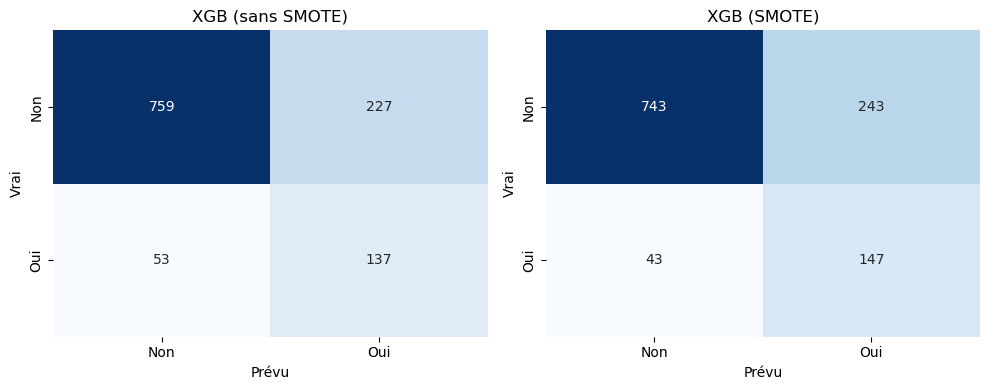

In [26]:
# --------- Fonction seuil optimal CV déjà existante -----------
def find_optimal_threshold_cv(model, X_train, y_train, beta=2, n_splits=5):
    thresholds = np.linspace(0, 1, 101)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresholds = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        f2_scores = [fbeta_score(y_fold_val, (y_proba_val >= t), beta=beta) for t in thresholds]
        best_idx = np.argmax(f2_scores)
        best_thresholds.append(thresholds[best_idx])

    return np.mean(best_thresholds)  # seuil optimal moyen CV

# --------- Calcul et reporting pour tous les modèles optimisés ----------
results = []
all_conf_matrices = {}

for name, model in best_models.items():
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    conf_matrices = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        best_t_cv = find_optimal_threshold_cv(model, X_fold_train, y_fold_train, beta=2, n_splits=5)
        model.fit(X_fold_train, y_fold_train)
        y_proba_val = model.predict_proba(X_fold_val)[:, 1]
        y_pred_val = (y_proba_val >= best_t_cv).astype(int)
        results.append(metrics_table(y_fold_val, y_pred_val, y_proba_val, f"{name}_fold{fold_idx+1}", best_t_cv))
        conf_matrices.append(confusion_matrix(y_fold_val, y_pred_val))
    all_conf_matrices[name] = np.sum(conf_matrices, axis=0)

df_metrics_cv = pd.DataFrame(results)
# ---------- Tableau moyenné --------------
numeric_cols = ['Seuil', 'Rappel (%)', 'Précision (%)', 'F2 (%)', 'PR-AUC (%)']
for col in numeric_cols:
    df_metrics_cv[col] = (
        df_metrics_cv[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .apply(lambda x: x.strip() if isinstance(x, str) else x)
        .replace('', np.nan)
        .astype(float)
    )

df_metrics_cv['Base'] = df_metrics_cv['Modèle'].str.replace('_fold[0-9]+', '', regex=True)
df_summary = df_metrics_cv.groupby('Base')[numeric_cols].mean().round(2)
display(df_summary)

# --------- Matrices de confusion sommées sur folds -------------
model_base_names = ["xgb_bal"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # 1 ligne, 2 colonnes
suffixes = ['', '_smote']
for col, suffix in enumerate(suffixes):
    key = f"{model_base_names[0]}{suffix}"
    cm_sum = all_conf_matrices[key]
    ax = axes[col]
    titre = f"{model_base_names[0].replace('_bal','').upper()}"
    if suffix == '':
        titre += " (sans SMOTE)"
    else:
        titre += " (SMOTE)"
    sns.heatmap(cm_sum, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non','Oui'], yticklabels=['Non','Oui'], ax=ax)
    ax.set_title(titre)
    ax.set_ylabel('Vrai')
    ax.set_xlabel('Prévu')

plt.tight_layout()
plt.show()


## 11. Evaluation finale (Test set)

,Modèle,Seuil,Accuracy (%),Précision (%),Rappel (%),F1 (%),F2 (%),PR-AUC (%)
0,XGB bal + SMOTE,0.55,76.2,37.6,74.5,50.0,62.3,55.0


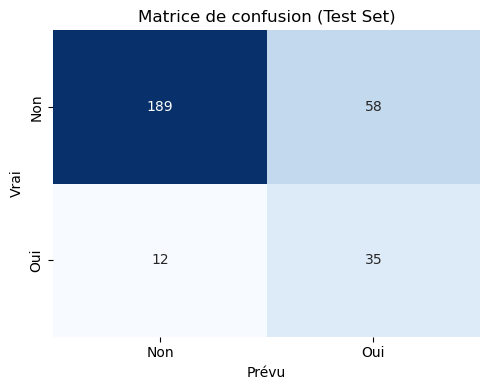

In [27]:
# ---- 1. Prédiction sur le test set ----
model = best_models['xgb_bal_smote']
best_threshold = 0.55

y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# ---- 2. Calcul des scores ----
tableau = metrics_table(y_test, y_pred_test, y_proba_test, "XGB bal + SMOTE", best_threshold)
display(pd.DataFrame([tableau]))

# ---- 3. Matrice de confusion ----
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non','Oui'], yticklabels=['Non','Oui'])
plt.title('Matrice de confusion (Test Set)')
plt.ylabel('Vrai')
plt.xlabel('Prévu')
plt.tight_layout()
plt.show()


## 12. Interprétabilité & Explicabilité

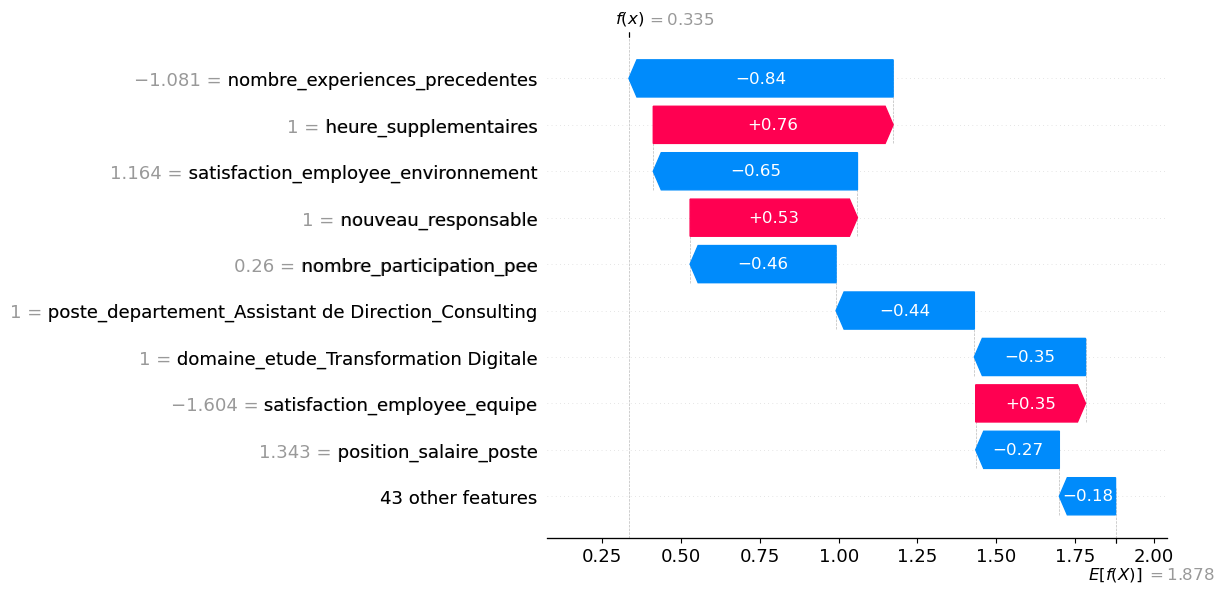

--- Valeurs brutes (features d'origine) pour le salarié classé OUI ---
age                                                                         36
revenu_mensuel                                                            3388
nombre_experiences_precedentes                                               0
annee_experience_totale                                                      2
annees_dans_l_entreprise                                                     1
annees_dans_le_poste_actuel                                                  0
satisfaction_employee_environnement                                          4
note_evaluation_actuelle                                                     3
note_evaluation_precedente                                                   2
niveau_hierarchique_poste                                                    1
satisfaction_employee_nature_travail                                         3
satisfaction_employee_equipe                                

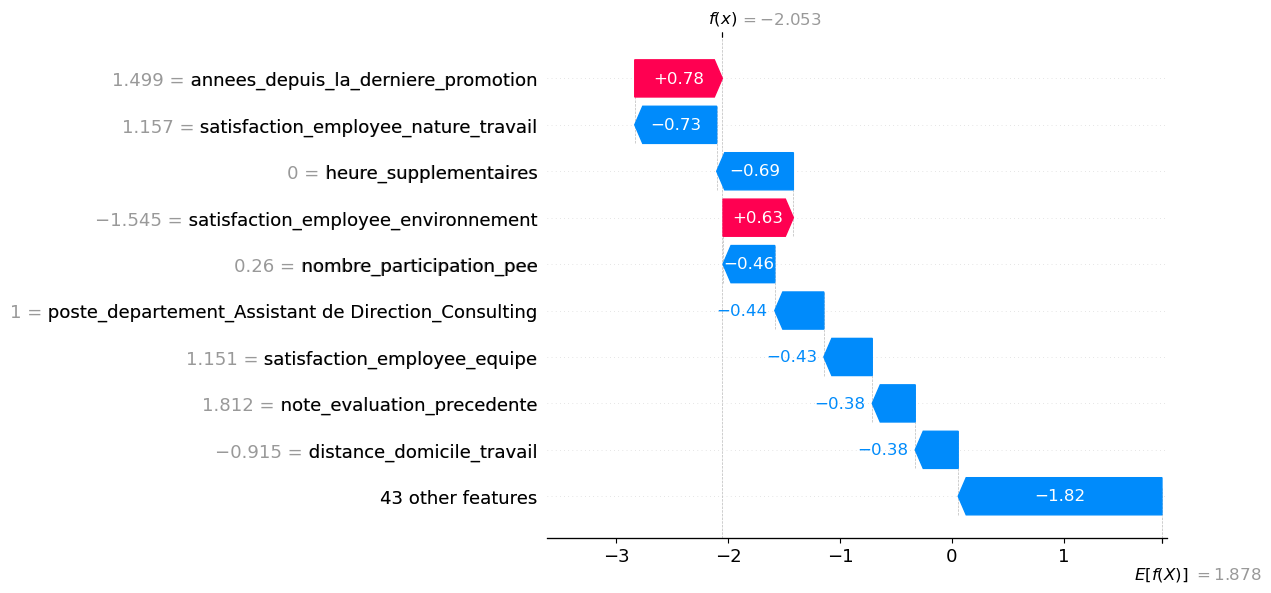

--- Valeurs brutes (features d'origine) pour le salarié classé NON ---
age                                                                         44
revenu_mensuel                                                            2011
nombre_experiences_precedentes                                               1
annee_experience_totale                                                     10
annees_dans_l_entreprise                                                    10
annees_dans_le_poste_actuel                                                  5
satisfaction_employee_environnement                                          1
note_evaluation_actuelle                                                     3
note_evaluation_precedente                                                   4
niveau_hierarchique_poste                                                    1
satisfaction_employee_nature_travail                                         4
satisfaction_employee_equipe                                

In [28]:
# Fonction d'affichage stylé de la prédiction
def display_prediction(prediction, score):
    if prediction == "OUI":
        html = f"<b><span style='color: red;'>OUI</span></b> (score = {score:.3f})"
    else:
        html = f"<b><span style='color: green;'>NON</span></b> (score = {score:.3f})"
    display(HTML(html))

# ---- Prédiction sur le test set ----
model_pipeline = best_models['xgb_bal_smote']
best_threshold = 0.55

y_proba_test = model_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# Indices du premier vrai Oui / vrai Non bien classés
mask_true_oui = (y_test == 1) & (y_pred_test == 1)
mask_true_non = (y_test == 0) & (y_pred_test == 0)
idx_true_oui = mask_true_oui[mask_true_oui].index[0] if mask_true_oui.sum() > 0 else y_test.index[0]
idx_true_non = mask_true_non[mask_true_non].index[0] if mask_true_non.sum() > 0 else y_test.index[0]

# Prépocessing sur X_test
X_test_processed = model_pipeline.named_steps['preprocessor'].transform(X_test)

# Récupère le modèle XGBoost natif
xgb_model = model_pipeline.named_steps['clf']

# Calcul des SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_processed)
base_value = explainer.expected_value

# Obtenir les noms des features après transformation
def get_feature_names(preprocessor, input_cols):
    feat_names = []
    for name, trans, cols in preprocessor.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(cols)
        elif hasattr(trans, 'get_feature_names'):
            names = trans.get_feature_names()
        else:
            names = cols
        feat_names.extend(names)
    return feat_names

feature_names_transformed = get_feature_names(model_pipeline.named_steps['preprocessor'], X_test.columns)

# Localisation des indices transformés
idx_oui = X_test.index.get_loc(idx_true_oui)
idx_non = X_test.index.get_loc(idx_true_non)

# Construction des objets Explanation SHAP
expl_oui = shap.Explanation(
    values=shap_values[idx_oui],
    base_values=base_value,
    data=X_test_processed[idx_oui],
    feature_names=feature_names_transformed
)
expl_non = shap.Explanation(
    values=shap_values[idx_non],
    base_values=base_value,
    data=X_test_processed[idx_non],
    feature_names=feature_names_transformed
)

shap.initjs()

# Pour le salarié OUI
idx_test_oui = X_test.index.get_loc(idx_true_oui)
score_oui = y_proba_test[idx_test_oui]
pred_oui = "OUI" if y_pred_test[idx_test_oui] == 1 else "NON"
display_prediction(pred_oui, score_oui)
shap.plots.waterfall(expl_oui)
print("--- Valeurs brutes (features d'origine) pour le salarié classé OUI ---")
print(X_test.loc[idx_true_oui])
print()

# Pour le salarié NON
idx_test_non = X_test.index.get_loc(idx_true_non)
score_non = y_proba_test[idx_test_non]
pred_non = "OUI" if y_pred_test[idx_test_non] == 1 else "NON"
display_prediction(pred_non, score_non)
shap.plots.waterfall(expl_non)
print("--- Valeurs brutes (features d'origine) pour le salarié classé NON ---")
print(X_test.loc[idx_true_non])
print()


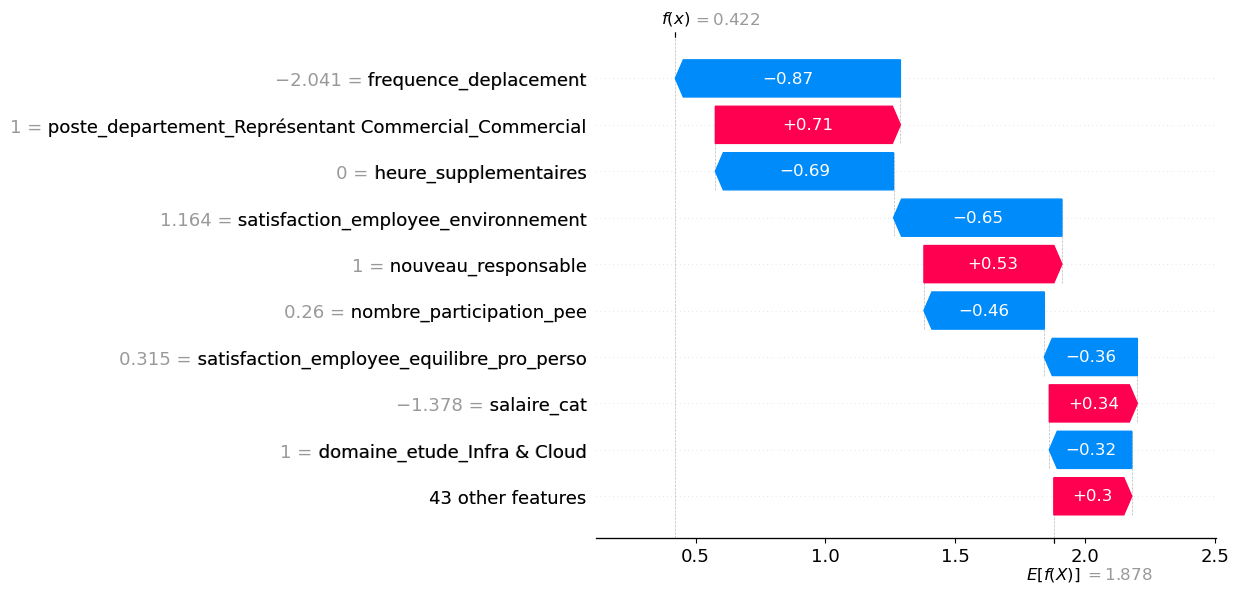

--- Valeurs brutes (features d'origine) pour l'employé choisi ---
id_employee                                                            1
age                                                                   41
revenu_mensuel                                                      5993
nombre_experiences_precedentes                                         8
annee_experience_totale                                                8
annees_dans_l_entreprise                                               6
annees_dans_le_poste_actuel                                            4
satisfaction_employee_environnement                                    2
note_evaluation_actuelle                                               3
note_evaluation_precedente                                             3
niveau_hierarchique_poste                                              2
satisfaction_employee_nature_travail                                   4
satisfaction_employee_equipe                              

interactive(children=(Dropdown(description='id_employee:', options=(1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, …

<function __main__.show_employee_expl(id_selected)>

In [36]:
# id_employee_list = liste des ID depuis le DataFrame brut, dans le bon ordre
id_employee_list = df['id_employee'].tolist()
id_selector = widgets.Dropdown(options=id_employee_list, description='id_employee:')

def show_employee_expl(id_selected):
    # Récupère la position de l'id dans la liste (car l'ordre est celui de X, y_pred, etc.)
    idx = id_employee_list.index(id_selected)
    
    score = y_proba_test[idx]
    pred = "OUI" if y_pred_test[idx] == 1 else "NON"
    color = "red" if pred == "OUI" else "green"
    display(HTML(f"<b><span style='color:{color};'>{pred}</span></b> (score = {score:.3f})"))
    
    # Waterfall SHAP
    shap.initjs()
    explainer = shap.TreeExplainer(model_pipeline.named_steps['clf'])
    expl = shap.Explanation(
        values=explainer.shap_values(X_test_processed)[idx],
        base_values=explainer.expected_value,
        data=X_test_processed[idx],
        feature_names=feature_names_transformed
    )
    shap.plots.waterfall(expl)
    
    print("--- Valeurs brutes (features d'origine) pour l'employé choisi ---")
    print(df.iloc[idx])
    print()

widgets.interact(show_employee_expl, id_selected=id_selector)


## 13 - Export du modèle

In [37]:
joblib.dump(model_pipeline, "../models/model_pipeline.joblib")


['../models/model_pipeline.joblib']

## 14 - Export PostgreSQL - SQLite 

In [38]:
import pandas as pd
from sqlalchemy import create_engine
import sqlite3

# --- Variables à adapter
PG_USER = "demo"
PG_PW = "demo_pw"
PG_HOST = "localhost"
PG_PORT = "5432"
PG_DB = "attrition_esn"
DB_CONNECT_PG = f"postgresql+psycopg2://{PG_USER}:{PG_PW}@{PG_HOST}:{PG_PORT}/{PG_DB}"
SQLITE_PATH = "db.sqlite"

# --- Connexion Postgres & export DataFrame
pg_engine = create_engine(DB_CONNECT_PG)
df_raw = pd.read_sql("SELECT * FROM raw", pg_engine)

# --- Connexion SQLite & injection table
conn_sqlite = sqlite3.connect(SQLITE_PATH)
df_raw.to_sql("raw", conn_sqlite, index=False, if_exists="replace")
conn_sqlite.commit()
conn_sqlite.close()

print(f"Export terminé : {len(df_raw)} lignes vers {SQLITE_PATH} (table raw).")


Export terminé : 1470 lignes vers db.sqlite (table raw).
